# Analyzing solving times of a world-class speedcuber - Philipp Weyer

**Speedcubing** is the activity of solving a variety of twisty puzzles as fast as possible. The most famous twisty puzzle from the Speedcubing domain (which is also responsible for shaping the term *Speedcubing*) is the widely-known [Rubik's Cube](https://en.wikipedia.org/wiki/Rubik%27s_Cube), or more generally **3x3x3 Cube** (since *Rubik's Cube* is technically a brand name). In recent years, the popularity of Speedcubing has grown exponentially all over the world, which can mainly be attributed to the efforts of its global governing body, the [World Cube Association (WCA)](https://www.worldcubeassociation.org/). In 2017 alone, there have been 925 WCA competitions in 88 different countries with 37547 distinct competitors.

One of these competitors is [Philipp Weyer](https://www.worldcubeassociation.org/persons/2010WEYE01). Philipp is currently (beginning of March 2018) placed 8th in the [3x3x3 Cube WCA world rankings](https://www.worldcubeassociation.org/results/events.php?eventId=333&regionId=&years=&show=100%2BPersons&average=Average) with an average of 6.77 seconds (for the WCA's *average of 5* format each competitor is alotted 5 attempts, the best and worst attempts are removed, and the arithmetic mean of the remaining 3 attempts counts for the competitor's result).

***Ok, that's all quite interesting, but what makes Philipp Weyer particularly interesting for data analysis?!***

To be able to achieve such astonishing results, world-class speedcubers like Philipp do a tremendous amount of practice solves at home. But while most speedcubers do not keep track of these results, **Philipp has accumulated a data set of *over 200.000 timed 3x3x3 solves* since November 2013! Moreover, Philipp has shared this data with me to analyze it!**

# Part II: Data analysis

In this second part of my analysis, I will perform the actual data analysis on Philipp's practice data & official results that were wrangled and cleaned in [Part I: Data wrangling & cleaning](Part_1_data_wrangling_cleaning.ipynb).

* [Data import](#Import-of-the-cleaned-data)
* [Initial overview](#Initial-overview)
* [Practice data: rolling averages](#Practice-data:-rolling-averages)
* [Practice data: progress analysis](#Practice-data:-progress-analysis)
* [Practice data vs. official results: Philipp's competition performance](#Practice-data-vs.-official-results:-Philipp's-competition-performance) 
  * [Z-scores](#Z-scores) 
  * [Linear regression](#Linear-regression)
* [Overcoming barriers: official sub7 average](#Overcoming-barriers:-official-sub7-average)
* [Conclusion](#Conclusion)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, re, scipy.stats
from IPython.display import HTML, display

## Import of the cleaned data

As a first step, I retrieve and verify the cleaned data.

In [2]:
## practice data
# import and verify data types
practice_data = pd.read_csv('clean_data/practice_data.csv', index_col='timestamp', parse_dates=True, 
                  usecols=['timestamp','value'])
assert practice_data.value.dtypes == np.float64

## official singles and averages
# import and verify data types
official_data = pd.read_csv('clean_data/official_results.csv', index_col='date', parse_dates=True, 
                  usecols=['date','competitionId','roundTypeId','attempt','value'])
assert official_data.value.dtypes == np.float64
assert official_data.roundTypeId.dtypes == np.object
assert official_data.attempt.dtypes == np.int64
official_data.roundTypeId = official_data.roundTypeId.astype('category')

# reduce the official results to the time frame of the practice data
min_date = practice_data.index.min()
official_data = official_data.loc[min_date:,:]

In [3]:
practice_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 235114 entries, 2013-11-16 21:53:57 to 2018-02-19 19:55:33
Data columns (total 1 columns):
value    235114 non-null float64
dtypes: float64(1)
memory usage: 3.6 MB


In [4]:
official_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2013-11-23 to 2018-02-17
Data columns (total 4 columns):
competitionId    600 non-null object
roundTypeId      600 non-null category
attempt          600 non-null int64
value            600 non-null float64
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 19.5+ KB


## Initial overview

Before starting further analysis, I first provide an initial descriptive overview of the data sets.

In [5]:
practice_data[['value']].describe()

value
count  235114.000000
mean        8.046510
std         1.192896
min         3.190000
25%         7.220000
50%         7.930000
75%         8.760000
max        20.460000

In [6]:
official_data[['value']].describe()

value
count  600.000000
mean     8.079850
std      1.243499
min      5.050000
25%      7.220000
50%      7.900000
75%      8.712500
max     14.940000

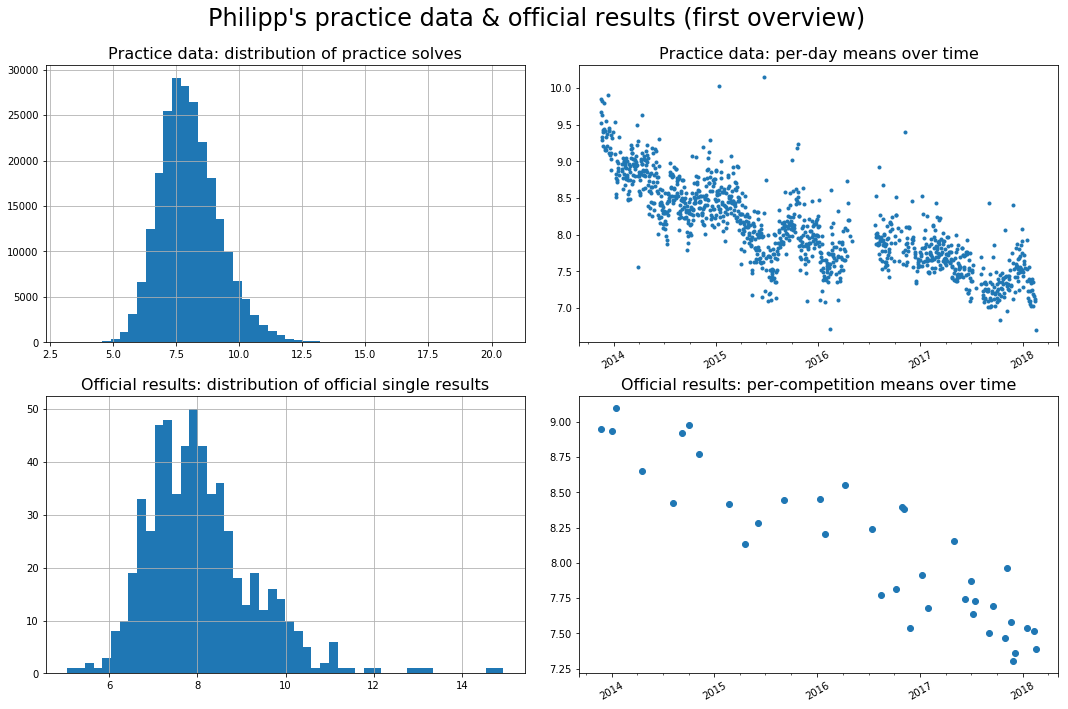

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

practice_data['value'].hist(ax=axes[0,0], bins=50)
axes[0,0].set_title('Practice data: distribution of practice solves', fontsize=16)

practice_mean_per_day = practice_data['value'].resample('D').mean()

practice_mean_per_day.plot(ax=axes[0,1], style='.', rot='30')
axes[0,1].set_title('Practice data: per-day means over time', fontsize=16)

official_data['value'].hist(ax=axes[1,0],bins=50)
axes[1,0].set_title('Official results: distribution of official single results', fontsize=16)

official_mean_per_comp = official_data['value'].resample('D').mean()

official_mean_per_comp.plot(ax=axes[1,1], style='o', rot='30')
axes[1,1].set_title('Official results: per-competition means over time', fontsize=16)

for i,j in [(0,0),(0,1),(1,0),(1,1)]:
    axes[i,j].set_xlabel('')

plt.suptitle('Philipp\'s practice data & official results (first overview)', fontsize=24)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show();

## Practice data: rolling averages

Even though the tables and plots above give a decent first overview, per-day means are not really suitable to describe the practice data since the number of practice solves Philipp made per day varies a lot:

In [8]:
practice_solves_per_day = practice_data.value.resample('D').count()
practice_solves_per_day.describe()

count    1557.000000
mean      151.004496
std       159.641120
min         0.000000
25%         4.000000
50%       110.000000
75%       231.000000
max      1087.000000
Name: value, dtype: float64

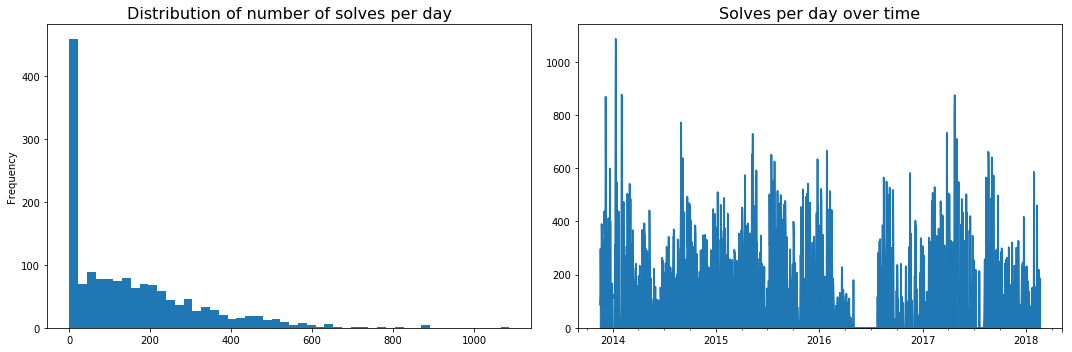

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

practice_solves_per_day.plot(ax=axes[0], kind='hist', bins = 50)
axes[0].set_title('Distribution of number of solves per day', fontsize=16)

practice_solves_per_day.plot(ax=axes[1], kind='area')
axes[1].set_title('Solves per day over time', fontsize=16)

for i in [0,1]:
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show();

As suggested above, these plots confirm that the number of practice solves Philipp made per day varies a lot. So instead of looking at those, a better way to measure pracitce times (and their development) are so-called *rolling averages of X*, which is the mean of the last X solves (after removing the best and worst 5%, rounded up). In the following I will look at numbers of X that speedcubers are typically interested in: 5, 12, 100, 1000.

**Note:** The solves per day over time plot also reveals a lack of data over a longer time period in 2016. Philipp told me that this was caused by switching to a new operating system, on which he first used a different timing software. Unfortunately, the data for this period is not available.

In [10]:
def get_average(array):
    """ 
    Helper function to return the average of a given range, removing the best and worst 5% of the given times. 
    In particular, the output correspinds to WCA's average of 5 format for 5 input times.
    """
    
    num = len(array)
    cut = int(np.ceil(num*0.05))
    sorted_array = np.sort(array)
    counting_times = sorted_array[cut:-cut]
    
    return np.round(counting_times.mean(),2)

In [11]:
average_sizes = [5,12,100,1000]
average_labels = ['average_of_' + str(x) for x in average_sizes]

for x, a in zip(average_sizes, average_labels):
    practice_data[a] = practice_data.value.rolling(window=x).apply(get_average)

The following table gives an overview of Philipps single times, as well as his rolling averages of 5, 12, 100 and 1000:

In [12]:
practice_data[['value'] + average_labels].describe()

value   average_of_5  average_of_12  average_of_100  \
count  235114.000000  235110.000000  235103.000000   235015.000000   
mean        8.046510       7.995051       8.008594        8.011335   
std         1.192896       0.769755       0.669440        0.579121   
min         3.190000       5.230000       6.020000        6.540000   
25%         7.220000       7.440000       7.520000        7.590000   
50%         7.930000       7.940000       7.960000        7.940000   
75%         8.760000       8.490000       8.460000        8.430000   
max        20.460000      11.990000      11.220000       10.000000   

       average_of_1000  
count    234115.000000  
mean          8.008844  
std           0.538754  
min           6.960000  
25%           7.600000  
50%           7.920000  
75%           8.430000  
max           9.530000

Naturally, *bigger* averages provide a better description of how fast Philipp actually is, therefore I visualize his averages of 100 and 1000 over time:

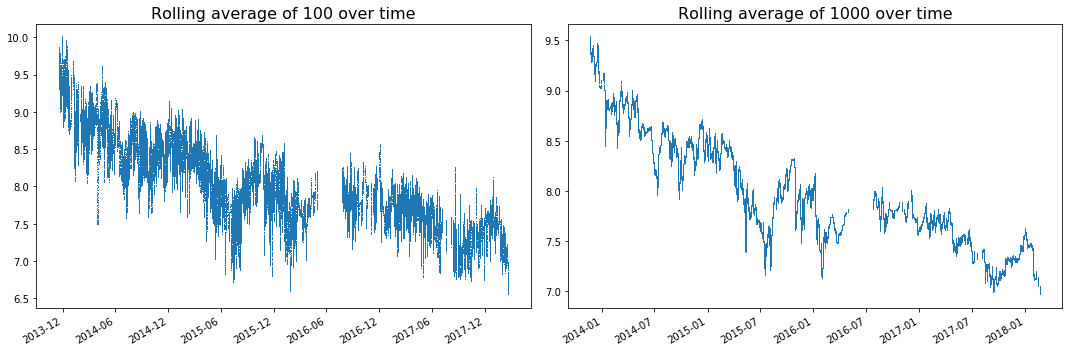

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

practice_data['average_of_100'].plot(ax=axes[0], style=',', rot='30')
axes[0].set_title('Rolling average of 100 over time', fontsize=16)

practice_data['average_of_1000'].plot(ax=axes[1], style=',', rot='30')
axes[1].set_title('Rolling average of 1000 over time', fontsize=16)

for i in [0,1]:
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show();

Interesting! Especially the average of 1000 plot shows some clear and partially surprising trends. I will focus on analyzing these further in the following.

## Practice data: progress analysis

My goal for this analysis is to look at Philipp's average of 1000 progression in more detail, using confidence intervals to determine statistically significant changes. Since 1000 solves represents quite a large sample size, it is reasonable to use [t-based confidence intervals](http://www.stat.wmich.edu/s216/book/node79.html) for estimating the true population mean (i.e. Philipp's *true speed* at a given time) based on a sample of 1000 consecutive solves. It should be noted that this approach assumes that the progress achieved within 1000 solves is negligible.

In [14]:
def get_average_CI_error_margin(array, alpha=0.99):
    """ returns the average of X of a given sample including the confidence interval at level alpha """
    
    num = len(array)
    cut = int(np.ceil(num*0.05))
    sorted_array = np.sort(array)
    ct = sorted_array[cut:-cut]
    
    av = np.round(ct.mean(),2)
    CI_lower, CI_upper = scipy.stats.t.interval(alpha, len(ct)-1, loc=av, scale=scipy.stats.sem(ct))
    error_margin = (CI_upper - CI_lower) / 2
    
    return error_margin

To calculate the confidence intervals, I am using a confidence level of $\alpha = 99\%$.

In [15]:
ao1000_data = practice_data[['value','average_of_1000']].copy()
ao1000_data['error_margin'] = ao1000_data.value.rolling(window=1000).apply(lambda x: get_average_CI_error_margin(x, alpha=0.99))
ao1000_data['CI_lower'] = ao1000_data['average_of_1000'] - ao1000_data['error_margin']
ao1000_data['CI_upper'] = ao1000_data['average_of_1000'] + ao1000_data['error_margin']

In [16]:
ao1000_data.describe()

value  average_of_1000   error_margin       CI_lower  \
count  235114.000000    234115.000000  234115.000000  234115.000000   
mean        8.046510         8.008844       0.069242       7.939602   
std         1.192896         0.538754       0.005838       0.534496   
min         3.190000         6.960000       0.048880       6.897295   
25%         7.220000         7.600000       0.064913       7.529940   
50%         7.930000         7.920000       0.068476       7.848147   
75%         8.760000         8.430000       0.072313       8.358866   
max        20.460000         9.530000       0.090554       9.449317   

            CI_upper  
count  234115.000000  
mean        8.078087  
std         0.543042  
min         7.022447  
25%         7.661143  
50%         7.987941  
75%         8.500071  
max         9.611163

Now, I will take the first average of 1000 as a reference and simply define it as *significant*. I then go through the data and iteratively look for the next average of 1000 and define it as *significant* if and only if it is (i) disjoint with the last significant average of 1000 and (ii) its confidence interval is also disjoint with the confidence interval of the last significant average of 1000.

In [17]:
ao1000_data = ao1000_data.dropna()
ao1000_data['significant'] = False
sig_index = ao1000_data.columns.get_loc('significant')
cil_index = ao1000_data.columns.get_loc('CI_lower')
ciu_index = ao1000_data.columns.get_loc('CI_upper')
curr_index = 0

while curr_index < len(ao1000_data):
    sig = False
    curr_CI = (ao1000_data.iloc[curr_index, cil_index], ao1000_data.iloc[curr_index, ciu_index])
    
    if curr_index == 0:
        sig = True
    elif curr_CI[1] < last_sig_CI[0] or last_sig_CI[1] < curr_CI[0]: # CIs are disjoint
        sig = True
            
    if sig == True:
        last_sig_index = curr_index
        last_sig_CI = curr_CI
        ao1000_data.iloc[curr_index, sig_index] = True
        # skip next 1000 rows
        ao1000_data.iloc[curr_index+1:curr_index+1000, sig_index] = False
        curr_index += 1000
    else:
        curr_index += 1    

Let's look at the result!

In [18]:
ao1000_data[ao1000_data.significant].describe()

value  average_of_1000  error_margin    CI_lower    CI_upper
count  144.000000       144.000000    144.000000  144.000000  144.000000
mean     7.908681         8.000556      0.069142    7.931414    8.069697
std      1.315800         0.511729      0.005726    0.507667    0.515823
min      5.280000         6.980000      0.055538    6.918590    7.041410
25%      6.852500         7.620000      0.065184    7.555716    7.686685
50%      7.800000         7.965000      0.068273    7.896574    8.033426
75%      8.812500         8.375000      0.071675    8.305758    8.443959
max     11.310000         9.530000      0.086500    9.448850    9.611150

144 significant averages of 1000! That's a surprisingly high number. Let's plot the significant averages of 1000 with their confidence intervals:

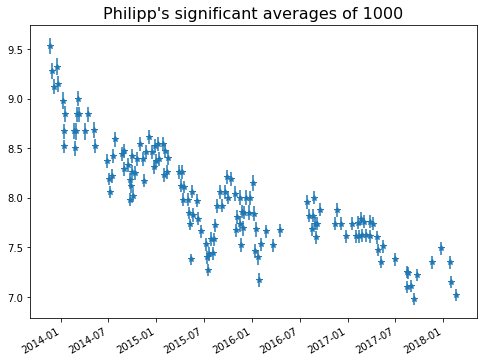

In [19]:
significant_ao1000 = ao1000_data[ao1000_data.significant].average_of_1000
ao1000_errors = ao1000_data[ao1000_data.significant].error_margin

significant_ao1000.plot(fmt='*', figsize=(8,6), yerr=ao1000_errors)
plt.title('Philipp\'s significant averages of 1000', fontsize=16)
plt.xlabel('')
plt.show()

This result is in fact very interesting and surprising. The plot shows that Philipp does not only improve statistically significant over time, but that he also had many averages of 1000 that very significantly worse then previous significant averages. 

The conclusion that can be drawn from this is that there must be other factors in play - *lurking variables* that cannot be derived from the present data. The most relevant such factor is probably Philipp's puzzle. For example, Philipp told me that he started using a 3x3x3 cube of the GAN brand at the beginning of 2015 and that he liked it very much. Consequently, we can see in the plot above that Philipp's average dropped a lot in the first half of 2015. However, his times increase again in the second half of 2015. This could possibly be attributed to his 3x3x3 cube wearing out and becoming worse over time. Similar explanations could apply to the similar trends in 2016 and 2017.

In any case, I can only speculate about the reasons behind these local trends here. But on the broader scope, it is obvious that Philipp has improved massively over time!

To close the progress analysis, I present some of Philipp's bigger milestones:

In [20]:
table = '<table><tr><th></th><th>value</th><th>CI (alpha = 0.99)</th><th>timestamp</th></tr>'

table += '<tr><td>First average of 1000:</td><td>{:.2f}</td><td>[{:.2f}, {:.2f}]</td><td>{}</td>'.format(
    ao1000_data.iloc[0]['average_of_1000'], ao1000_data.iloc[0]['CI_lower'], 
    ao1000_data.iloc[0]['CI_upper'], ao1000_data.index[0])

for i in [9.0, 8.5, 8.0, 7.5]:
    ti = ao1000_data[ao1000_data.average_of_1000 < i].index[0]
    ri = ao1000_data.index.get_loc(ti)
    table += '<tr><td>First sub-{} average of 1000:</td><td>{:.2f}</td><td>[{:.2f}, {:.2f}]</td><td>{}</td>'.format(i, 
        ao1000_data.iloc[ri]['average_of_1000'], ao1000_data.iloc[ri]['CI_lower'], ao1000_data.iloc[ri]['CI_upper'], str(ti))
    
ti = ao1000_data.CI_upper.idxmin()
ri = ao1000_data.index.get_loc(ti)
table += '<tr><td>Best average of 1000:</td><td>{:.2f}</td><td>[{:.2f}, {:.2f}]</td><td>{}</td>'.format(
    ao1000_data.iloc[ri]['average_of_1000'], ao1000_data.iloc[ri]['CI_lower'], ao1000_data.iloc[ri]['CI_upper'], str(ti))

table += '</table>'

display(HTML(table))

## Practice data vs. official results: Philipp's competition performance

After analyzing Philipp's practice data in depth, I would now like to compare his official results with his practice data. Or in other words, I would like to judge his official performance based on what could be expected from his practice results. Since single results are generally prone to high fluctuation, I will focus on the average of 5 results only.

As a first step, I have to calculate the averages of 5 for Philipp's official 3x3x3 rounds.

In [21]:
comp_averages = official_data.pivot_table(index=['competitionId','roundTypeId'], aggfunc=get_average).reset_index()
comp_rounds = official_data[['competitionId','roundTypeId']].drop_duplicates().reset_index()
official_averages = comp_rounds.merge(comp_averages, on=['competitionId','roundTypeId'])
official_averages = official_averages.set_index('date').rename(columns={'value': 'average'}).drop('attempt', axis=1)
official_averages.head()

competitionId roundTypeId  average
date                                                
2013-11-23  GermanNationals2013           1     8.58
2013-11-23  GermanNationals2013           2     9.06
2013-11-23  GermanNationals2013           f     8.99
2014-01-03   DuisburgWinter2014           1     9.01
2014-01-03   DuisburgWinter2014           2     8.71

Let's have a look at them!

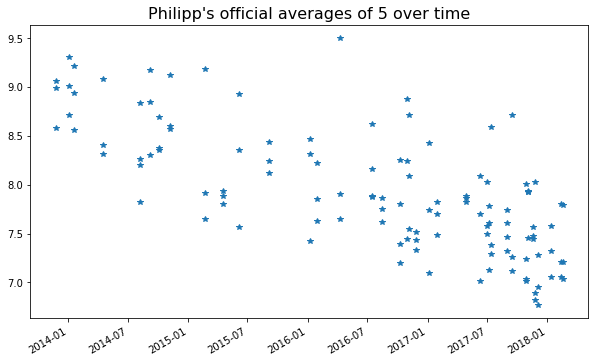

In [22]:
official_averages['average'].plot(style='*', figsize=(10,6))
plt.title('Philipp\'s official averages of 5 over time', fontsize=16)
plt.xlabel('')
plt.show()

### Z-scores

To obtain a base for judging Philipp's official performance based on his practice results, I will now take the following approach:

1. For each point in time, I calculate the rolling mean and standard deviation of the last 1000 averages of 5.
2. I resample the data to a daily period, always taking the last values for each day and filling days without practice solves with the values from the most recent available values.
3. I merge this data with Philipp's official average data, so that each official average is matched with the rolling mean and standard deviation of the last 1000 averages of 5 he did prior to the respective competition.
4. I use these values to compute [Z-scores](https://en.wikipedia.org/wiki/Standard_score) for the official averages, i.e. the number of standard deviations that the average is away from the mean of Philipp's most recent 1000 averages of 5 at home. The Z-scores will then serve as normalized scores to judge Philipp's official performance.

In [23]:
# step 1
ao5_data = practice_data[['average_of_5']].copy()
ao5_data['rolling_ao5_mean'] = ao5_data.average_of_5.rolling(window=1000).mean()
ao5_data['rolling_ao5_std'] = ao5_data.average_of_5.rolling(window=1000).std()
ao5_data = ao5_data[['rolling_ao5_mean','rolling_ao5_std']].resample('D').last().ffill().dropna()
ao5_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1551 entries, 2013-11-22 to 2018-02-19
Freq: D
Data columns (total 2 columns):
rolling_ao5_mean    1551 non-null float64
rolling_ao5_std     1551 non-null float64
dtypes: float64(2)
memory usage: 36.4 KB


In [24]:
# step 2 & 3
ao5_data_comp_dates = ao5_data.reindex(official_averages.index.unique(), method='ffill')
official_averages = official_averages.merge(ao5_data_comp_dates, left_index=True, right_index=True)
official_averages.head()

competitionId roundTypeId  average  rolling_ao5_mean  \
date                                                                     
2013-11-23  GermanNationals2013           1     8.58           9.29862   
2013-11-23  GermanNationals2013           2     9.06           9.29862   
2013-11-23  GermanNationals2013           f     8.99           9.29862   
2014-01-03   DuisburgWinter2014           1     9.01           9.08285   
2014-01-03   DuisburgWinter2014           2     8.71           9.08285   

            rolling_ao5_std  
date                         
2013-11-23         0.618688  
2013-11-23         0.618688  
2013-11-23         0.618688  
2014-01-03         0.622664  
2014-01-03         0.622664

In [25]:
# step 4
official_averages['zscore'] = (official_averages['average'] - 
                               official_averages['rolling_ao5_mean']) / official_averages['rolling_ao5_std']
official_averages[['zscore']].describe()

zscore
count  120.000000
mean     0.329345
std      0.955599
min     -1.456960
25%     -0.449612
50%      0.307313
75%      0.925322
max      3.704543

Great, this worked well! The table above now shows the descriptive summary of the calculated Z-scores, which already gives a good first insight. The mean of ~0.33 for example is very interesting. This shows that Philipp on average performs worse in competition compared to his practice results. Further, the absolute values of the minimum and the 25% quantile are lower than the maximum value and the 75% quantile, which shows that it is easier to get a particularly bad average in competition than a particularly good one. 

All of this is not very surprising, since the conditions during official WCA competitions are generally more stressful and the pressure is significantly higher compared to practicing at home. Given this, I would still say that Philipp performs pretty well during official competitions and that an average Z-score of ~0.33 is very reasonable.

In particular, Philipp still managed to beat his recent home results in 44 out of 120 official averages since November 2013:

In [26]:
np.sign(official_averages['zscore']).value_counts()

 1.0    76
-1.0    44
Name: zscore, dtype: int64

Moreover, here are Philipp's top 5 averages with lowest Z-scores (the relatively best averages):

In [27]:
official_averages.sort_values('zscore').head()

competitionId roundTypeId  average  rolling_ao5_mean  \
date                                                                     
2015-02-21       HessenOpen2015           f     7.65           8.46067   
2014-08-08             Euro2014           3     7.82           8.57976   
2013-11-23  GermanNationals2013           1     8.58           9.29862   
2016-10-07  GermanNationals2016           3     7.20           7.79254   
2017-01-06        Cubelonia2017           2     7.10           7.62019   

            rolling_ao5_std    zscore  
date                                   
2015-02-21         0.556412 -1.456960  
2014-08-08         0.532896 -1.425718  
2013-11-23         0.618688 -1.161522  
2016-10-07         0.527621 -1.123041  
2017-01-06         0.485806 -1.070778

Also, here are the top 5 averages with highest Z-scores (the relatively worst averages):

In [28]:
official_averages.sort_values('zscore', ascending=False).head()

competitionId roundTypeId  average  rolling_ao5_mean  \
date                                                                      
2016-04-09        GermanOpen2016           2     9.50           7.61733   
2017-09-16  MonnemCityCubing2017           f     8.71           7.09392   
2017-07-13                WC2017           3     8.59           7.34531   
2015-06-06       VelbertOpen2015           1     8.93           7.85528   
2016-10-29         SebraOpen2016           1     8.88           7.86253   

            rolling_ao5_std    zscore  
date                                   
2016-04-09         0.508206  3.704543  
2017-09-16         0.489680  3.300277  
2017-07-13         0.465345  2.674768  
2015-06-06         0.536347  2.003777  
2016-10-29         0.524101  1.941361

Out of the averages with highest Z-score above, the most interesting one is probably the one from the semi-finals of the Speedcubing World Championships 2017 (WC2017), which cost Philipp the participation in the finals. At the time, Philipp was very upset about his performance and stated that this average was terrible for him compared to his home results. My analysis definitely proves him right.

### Linear regression

Before visualizing the Z-scores, I will apply linear regression to determine how the Z-scores have developed over time.

In [29]:
official_averages['days_passed'] = (official_averages.index - official_averages.index.min()).astype('timedelta64[D]')
linregress_zscore = scipy.stats.linregress(official_averages.days_passed, official_averages['zscore'])
slope, intercept, r_value, p_value, std_err = linregress_zscore
linregress_zscore

LinregressResult(slope=0.00036508684808091694, intercept=-0.017089014388433466, rvalue=0.18614639749556713, pvalue=0.041788931561967058, stderr=0.00017739559890737544)

Alright, that's a pretty good result! The slope of the linear regression line is positive (although very small), which means that Philipp actually got slightly worse in competition over time compared to his practice results. This actually makes sense, because ranking higher in the world naturally increases pressure. However, this must definitely not be overinterpreted, especially because the 99% confidence interval for the slope includes zero:

In [30]:
(slope - scipy.stats.norm.ppf(0.995) * std_err, slope + scipy.stats.norm.ppf(0.995) * std_err)

(-9.1853933905307989e-05, 0.00082202763006714182)

However, the p-value of ~0.04 allows to reject the null hypothesis that the slop is zero at a confidence level of 95%. At last, the r-squared value of ~0.186 tells us that the regression line is able to explain ~18.6% of the total variance observed, which is acceptable for a linear model given the high variance of the Z-scores.

Finally, here is a visualization of the Z-scores over time including their regression line:

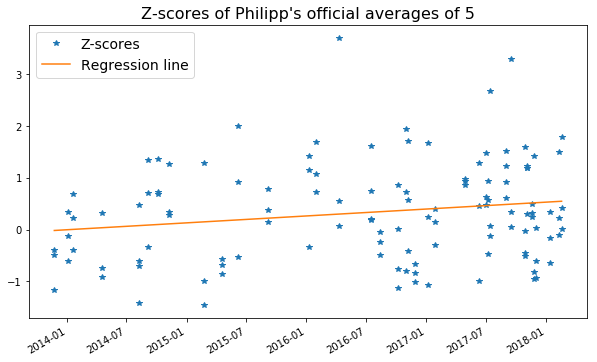

In [31]:
official_averages['zscore'].plot(style='*', figsize=(10,6), label='Z-scores')
official_averages['linregress'] = (official_averages['days_passed'] * slope) + intercept
official_averages['linregress'].plot(label='Regression line')
plt.title('Z-scores of Philipp\'s official averages of 5', fontsize=16)
plt.xlabel('')
plt.legend(fontsize=14)
plt.show()

## Overcoming barriers: official sub7 average

Before coming to the end of my analysis of Philipp's data, I want to devote another short analysis to a very particular topic: Philipp's quest for an official average below 7 seconds. Since I experienced Philipp at WCA competitions myself, I know that he struggled with this goal for the majority of 2017, before finally reaching his goal in November 2017:

In [32]:
official_averages[official_averages.average < 7][['competitionId','roundTypeId','average']]

competitionId roundTypeId  average
date                                                   
2017-11-25                WSMO2017           1     6.82
2017-11-25                WSMO2017           f     6.89
2017-12-02  BerlinKubusProjekt2017           2     6.95
2017-12-02  BerlinKubusProjekt2017           f     6.77

As can be seen above, Philipp not only achieved a sub7 average in competition, but he also achieved more such averages afterwards. It almost seems like once this goal was achieved a lot of pressure was gone. This inspired me to ask the following question: *Did finally breaking this barrier lead to a statistically significant improvement in Philipp's performance?*

To answer this question, I will first have a look at Philipp's mean Z-score before breaking the sub7 barrier (starting at the beginning of 2017) and after breaking the sub7 barrier:

In [33]:
official_averages['2017-01-01':'2017-11-24'].zscore.mean()

0.62721657419316

In [34]:
official_averages['2017-11-25':].zscore.mean()

0.10189064731354085

Indeed, there is a clear difference between both means. But is that difference statistically significant? To answer this, I will use the [Mann–Whitney *U* test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test), which allows for hypothesis testing without making assumptions about the underlying distributions. The test assumes as null hypothesis that both samples originate from the same distribution. If the returned p-value is below a certain threshold (determined by the chosen confidence level), the null hypothesis can be rejected in favour of the alternative hypothesis that the underlying distributions are different.

Let's do the test!

In [35]:
before_sub7 = official_averages['2017-01-01':'2017-11-24'].zscore.values
after_sub7 = official_averages['2017-11-25':].zscore.values
scipy.stats.mannwhitneyu(before_sub7, after_sub7)

MannwhitneyuResult(statistic=186.0, pvalue=0.020322646045552041)

Indeed, the test statistic returns a p-value of ~0.02, so that the null hypothesis can be rejected at a confidence level of $\alpha > 95\%$. For the given situation, this means that breaking the sub7 barrier did indeed cause a statistically significant improvement of Philipp's official performance!

Last but not least, it is good practice to report an effect size for such an inferential test. According to Wikipedia, a common measure of effect size for the Mann–Whitney U test is the so-called [common language effect size](http://core.ecu.edu/psyc/wuenschk/docs30/CL.pdf), which provides an estimate for the probability that a randomly selected score from the one population will be greater than a randomly sampled score from the other population. To calculate the common language effect size, I generate all possible pairs between both samples and determine the proportion of pairs where the before-sub7 Z-score is greater than the after-sub7 Z-score.

In [36]:
pairs = [(x,y) for x in before_sub7 for y in after_sub7]
print('Common language effect size: {:.2f}%'.format(100*len([p for p in pairs if p[0] > p[1]])/len(pairs)))

Common language effect size: 68.21%


This can be translated to saying that there is a 68.21% chance that Philipp performs better in near-future competitions than before achieving his first oficial sub7 average. Therefore: Good luck Philipp!

## Conclusion

Analyzing Philipp's data has definitely been a fun project and thus I want to thank Philipp once more for providing his practice dataset to me. Overall, I think I have extracted a couple of interesting results and I hope that others reading this analysis will share this feeling!